[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiptos/is_notes/blob/main/lstm_stock_prediction.ipynb)

# Prediction with LSTM


The current notebook performs timeseries prediction on NASDAQ index.

First, it is necessary to load the required libraries.

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

torch.manual_seed(1)

Set the processing device to accelerate the computation.

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = 'cpu'
print('Using {} device'.format(device))

Using mps device


## Set the parameters

The overall parameters allow setting the previous `sequence_length` days and the train/test ratio.

In [3]:
# set manual parameters
sequence_length = 20  # use previous 19 days to predict the 20th day
test_ratio = 0.2  # train on the first 80% data and test on the rest 20%

## Import dataset

 Import the NASDAQ index data and visualize it

              Close/Last          Open          High           Low
Date                                                              
2024-11-26  20922.900391  20871.550781  20944.900391  20832.400391
2024-11-25  20804.890625  20918.759766  20998.480469  20712.380859
2024-11-22  20776.230469  20737.490234  20797.240234  20655.720703
2024-11-21  20740.779297  20775.269531  20814.929688  20436.800781
2024-11-20  20667.099609  20660.839844  20676.570312  20402.550781
...                  ...           ...           ...           ...
2014-12-03   4312.930176   4312.169922   4319.020020   4287.040039
2014-12-02   4305.959961   4291.330078   4312.919922   4283.890137
2014-12-01   4287.810059   4323.950195   4332.549805   4274.680176
2014-11-28   4337.779785   4330.959961   4347.089844   4326.200195
2014-11-27   4317.990234      0.000000      0.000000      0.000000

[2527 rows x 4 columns]


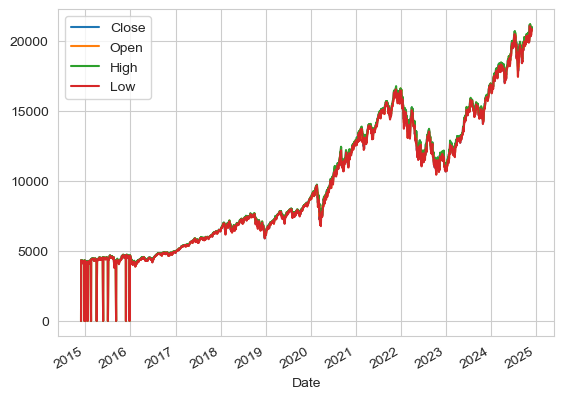

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/xiptos/is_notes/refs/heads/main/datasets/ndx.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.astype({'Close/Last': 'float32', 'Open': 'float32', 'High': 'float32', 'Low': 'float32'})
df = df.sort_values(by='Date', ascending=False)
df_view = df.set_index('Date')
print(df_view)

df_view['Close/Last'].interpolate().plot()
df_view['Open'].interpolate().plot()
df_view['High'].interpolate().plot()
df_view['Low'].interpolate().plot()
plt.legend(['Close', 'Open', 'High', 'Low'])
# we only predict on Close data in the following

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2527 entries, 0 to 2526
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2527 non-null   datetime64[ns]
 1   Close/Last  2527 non-null   float32       
 2   Open        2527 non-null   float32       
 3   High        2527 non-null   float32       
 4   Low         2527 non-null   float32       
dtypes: datetime64[ns](1), float32(4)
memory usage: 59.4 KB


## Create data loader

> Note: normalize the stock value to avoid node saturation

In [7]:
def load_data(stock_raw, sequence_length):
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(stock_raw) - sequence_length):
        data.append(stock_raw[index: index + sequence_length])

    data = np.array(data)
    test_set_size = int(np.round(test_ratio * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = np.reshape(data[:train_set_size, :-1], (train_set_size, sequence_length - 1, 1)) / 10000
    y_train = np.reshape(data[:train_set_size, -1], (train_set_size, 1)) / 10000

    x_test = np.reshape(data[train_set_size:, :-1], (test_set_size, sequence_length - 1, 1)) / 10000
    y_test = np.reshape(data[train_set_size:, -1], (test_set_size, 1)) / 10000

    return [x_train, y_train, x_test, y_test]


x_train, y_train, x_test, y_test = load_data(df['Close/Last'], sequence_length)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (2006, 19, 1)
y_train.shape =  (2006, 1)
x_test.shape =  (501, 19, 1)
y_test.shape =  (501, 1)


In [8]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).to(device)
x_test = torch.from_numpy(x_test).to(device)
y_train = torch.from_numpy(y_train).to(device)
y_test = torch.from_numpy(y_test).to(device)

In [9]:
n_steps = sequence_length - 1
batch_size = 20

train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=1, shuffle=False)

## Build the 2-layer stateless LSTM model

In [10]:
# Build model
#####################
input_dim = 1
hidden_dim = 128
num_layers = 2
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, device="cpu"):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # use stateless LSTM
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_dim),
                            torch.zeros(1, 1, self.hidden_dim))

        # Building your LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, device=device)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim, device=device)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out



## Train

In [84]:
# Train model
#####################
num_epochs = 2000

hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = sequence_length - 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device)

loss_fn = torch.nn.L1Loss()

optimiser = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.train()
for t in range(num_epochs):

    # Forward pass
    for x_epoch, y_epoch in train_loader:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_dim),
                             torch.zeros(1, 1, model.hidden_dim))

        x_epoch = x_epoch.to(device)
        y_train_pred = model(x_epoch)

        loss = loss_fn(y_train_pred, y_epoch)
        hist[t] += loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()

    if t % 200 == 0 and t != 0:
        print("Epoch ", t, "MSE: ", hist[t])

Epoch  200 MSE:  1.6755391908809543
Epoch  400 MSE:  1.429043575655669
Epoch  600 MSE:  1.3951387791894376
Epoch  800 MSE:  1.3097026785835624
Epoch  1000 MSE:  1.2602327354252338
Epoch  1200 MSE:  1.2438979893922806
Epoch  1400 MSE:  1.2616565790958703
Epoch  1600 MSE:  1.214383080136031
Epoch  1800 MSE:  1.1917703421786427


## Save

Since training takes some time, lets keep the model on disk.

In [85]:
PATH = "lstm_stock_prediction.pth"
torch.save(model.state_dict(), PATH)

## Load

Should we have already the model pretrained, let's load it.

In [11]:
from pathlib import Path

# File path
file_path = Path("lstm_stock_prediction.pth")

# Check if the file exists
if file_path.is_file():
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,
                 device=device)
    model.load_state_dict(torch.load(file_path, weights_only=True))
    model.eval()
else:
    print("File does not exist.")

## Visualize test result

Here we show the predictions (`pred`) over the real data (`x_testtime`).

Test Score: 0.00 RMSE


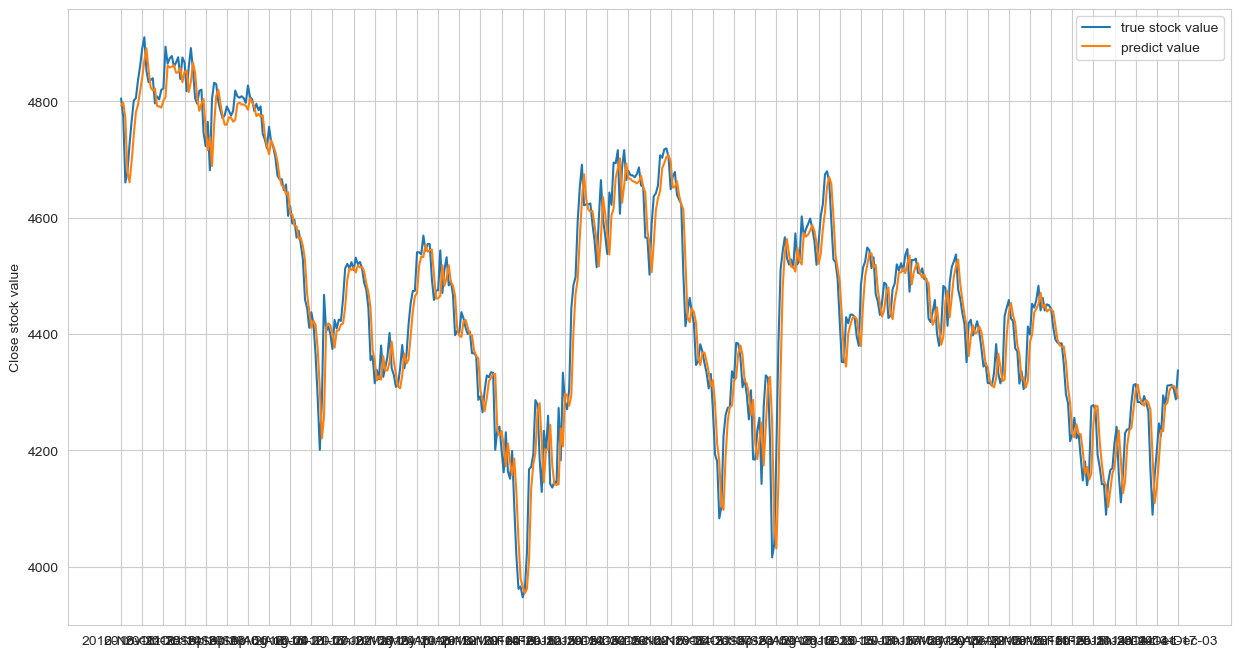

In [12]:
# make predictions
test_set_size = int(np.round(test_ratio * df['Close/Last'].shape[0]));
train_set_size = df['Close/Last'].shape[0] - (test_set_size);
time_stamp = pd.to_datetime(df['Date'])[train_set_size:]
timestamp_str = time_stamp.apply(lambda x: x.strftime('%Y-%b-%d'))

test_score = 0.0
y_test_pred = []
model.eval()
for x_testtime, y_testtime in test_loader:
    pred = model(x_testtime)
    pred = pred.detach().cpu().numpy()
    test_score += (pred[0, 0] - y_testtime) ** 2
    y_test_pred.append(pred[0, 0])

# print(y_test_pred)
print('Test Score: %.2f RMSE' % (math.sqrt(test_score / test_set_size)))

plt.figure(figsize=(15, 8))
a = [10000 * r for r in np.ndarray.tolist(np.reshape(y_test[:, 0].detach().cpu().numpy(), [len(y_test_pred)]))]
plt.plot(a)
plt.plot([10000 * r for r in y_test_pred])
plt.legend(['true stock value', 'predict value'])
xtick = range(0, test_set_size, 10)
xticklabel = timestamp_str[0:test_set_size:10]
plt.xticks(xtick, xticklabel)
plt.ylabel('Close stock value')
plt.show()